# 強化学習
### 懸案すべき事項
- 果たしてネットワークを入れることは有用なのか
- ゲーム理論を導入した研究は他にないか
- 基礎研究->具体例の流れにしたいが，妥当な問題は何か
- 全員が強化学習エージェントであるべきか？ヒューリスティックエージェントを入れるべきではないか？利己的など

In [125]:
# from __future__ import division
import numpy as np
import random
import collections
import warnings
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

## 多腕バンディット問題

### greedy algorithm

In [2]:
def greedy(trials, rewards, n):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param n greedy algorithm parameter
    @return selected arm position
    """
    if np.min(trials) < n:
        return np.argmin(trials)
    else:
        return np.argmax(rewards / trials)

### ε-greedy algorithm

In [3]:
def eps_greedy(trials, rewards, eps):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param eps ε-greedy algorithm parameter
    @return selected arm position
    """
    if np.min(trials) == 0:
        return np.argmin(trials)
    elif np.random.rand() < eps:
        return np.random.randint(len(trials))
    else:
        return np.argmax(rewards / trials)

### 楽観的初期値法(optimistic initial values)

In [4]:
def optimistic_init_val(trials, rewards, r_sup):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param r_sup optimistic initial values algorithm parameter
    @return selected arm position
    """
    K = len(trials)
    return np.argmax((trials+K*r_sup)/(reward+K))

### UCB1 (Upper Confidence Bound) algorithm

In [5]:
def UCB1(trials, rewards, R):
    """
    @param trials each arm's trial num
    @param rewards each arm's reward
    @param R UCB1 algorithm parameter
    @return selected arm position
    """
    if np.min(trials) == 0:
        return np.argmin(trials)
    mu = rewards / trials
    U = R * np.sqrt((2*np.log(np.sum(trials)))/trials)
    return np.argmax(mu+U) 

### スロットの定義

In [10]:
class slot(object):
    def __init__(self, name, prob_reward_lst):
        self.name = name
        self.convert_pr_lst(prob_reward_lst)
        
    def convert_pr_lst(self, prob_reward_lst):
        start = 0
        self.pr_range = []
        for ele in prob_reward_lst:
            self.pr_range.append([[start, start+ele[0]], ele[1]])
            start += ele[0]
        if not start == 1: #もし確率が1出なかったらエラー
            warnings.warn('Illegal reward function!!!')
    
    def turn(self):
        prob = np.random.rand()
        for ele in self.pr_range:
            if (ele[0][0] <= prob) and (prob <= ele[0][1]):
                return ele[1]

### ゲームの定義

In [41]:
R = 20
PLAY_NUM = 100
TIME_STEP = 10000

arm_a  = slot("a", [[0.2, R], [0.8, 0]])
arm_b  = slot("b", [[0.3, R], [0.7, 0]])
arm_c  = slot("c", [[0.4, R], [0.6, 0]])
arm_d  = slot("d", [[0.5, R], [0.5, 0]])

arms = np.array([arm_a, arm_b, arm_c, arm_d])
average_rewards = np.zeros(TIME_STEP) #length TIME_STEP
selected_arms = np.zeros((TIME_STEP, len(arms))) #length len(arms) * TIME_STEP

for i in tqdm.tqdm(range(PLAY_NUM)):
    trials = np.zeros(len(arms))
    rewards = np.zeros(len(arms))
    
    for j in xrange(TIME_STEP):
        arm = UCB1(trials, rewards, R) #多腕バンディットアルゴリズム
        reward = arms[arm].turn()
        trials[arm] += 1
        rewards[arm] += reward
        selected_arms[j, arm] += 1
        average_rewards[j] += reward
        
average_rewards = np.array(average_rewards) / PLAY_NUM
selected_arms = np.array(selected_arms) / PLAY_NUM

100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


### 結果の描画

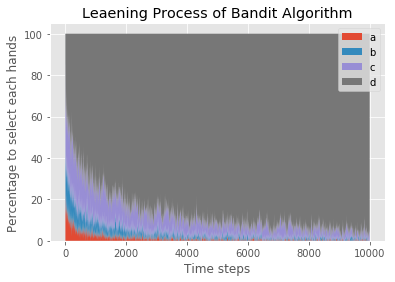

In [42]:
selected_arms = np.array(selected_arms) * 100 #パーセントにキャスト
x = np.arange(TIME_STEP)
# スタックプロット
fig, ax = plt.subplots()
ax.stackplot(x, selected_arms.T, labels=["a","b","c","d"])
plt.legend()
plt.title("Leaening Process of Bandit Algorithm")
plt.xlabel("Time steps")
plt.ylabel("Percentage to select each hands")
plt.show()

## シングルエージェント強化学習

### 環境構築

In [21]:
A = np.array(["入口に戻る", "東", "西"])
S = np.array(["山賊","湖","入口","森","宝"])
#R(s,a,s′): ここは問題によって引数も値も変わる．今回は遷移先の状態のみを見る
reward = {"山賊":-10,"湖":0,"入口":0,"森":0,"宝":10}
#遷移テーブル
ENV = pd.DataFrame({"入口に戻る": ["入口", np.NaN, np.NaN, np.NaN,"入口"], "東":[np.NaN,"入口","森","宝", np.NaN], "西":[np.NaN,"山賊","湖","入口", np.NaN]}, index=S)

### 行動選択手法
ref : マルチエージェント学習 p.28 高玉圭樹

In [22]:
#グリーディ方策
def greedy(q_row):
    """
    @param q_row q_table row of object state s
    @return selected action arg
    """
    return np.nanargmax(q_row)

In [23]:
#イプシロングリーディ方策
def eps_greedy(q_row, eps=0.1):
    """
    @param q_row q_table row of object state s
    @param eps random probability parameter
    @return selected action arg
    """
    prob = np.random.rand()
    if prob <= eps:
        return np.random.choice(np.where(np.invert(np.isnan(q_row)))[0])
    else:
        return np.nanargmax(q_row)

In [24]:
#ボルツマンソフトマックス方策
def softmax_boltzman(q_row, T=1.0):
    """
    @param q_row q_table row of object state s
    @param T temperature parameter
    @return selected action arg
    """
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))]
    q_row = q_row[np.invert(np.isnan(q_row))]
    #TODO Tの温度管理を実装
    return np.random.choice(obj, p=(np.exp(q_row / T))/np.sum(np.exp(q_row / T)))

In [25]:
#ルーレットソフトマックス方策
#Q値がマイナスをとるときは適用不可能
def softmax_roulette(q_row):
    """
    @param q_row q_table row of object state s
    @return selected action arg
    """
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))]
    q_row = q_row[np.invert(np.isnan(q_row))]
    return np.random.choice(obj, p=q_row / np.sum(q_row))

In [26]:
#ランダム方策
def random_select(q_row):
    """
    @param q_row q_table row of object state s
    @return selected action arg
    """
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))]
    return np.random.choice(obj)

### 学習手法(ブートストラップ型学習)
ref : マルチエージェント学習 p.35 高玉圭樹

In [30]:
#Q学習
def q_learning(S, A, s_0, s_t, n_iter=1000):
    """
    @param S state set
    @param A action set
    @param s_0 initial state
    @param s_t terminal state
    @param n_iter iteration number
    @return reward list of each timestep
    @return q value table
    """
    gamma = 0.9
    #initialize q_table
    q_table = ENV.copy()
    q_table[q_table.notnull()] = 1
    #q_table = pd.DataFrame(np.ones(len(S), len(A)), index=S, columns=A) #optimistic initial value
    #q_table = pd.DataFrame(np.ones(len(S), len(A)) * (-1), index=S, columns=A) #pessimistic initial value
    reward_lst = []
    for k in range(n_iter):
        alpha = 1/(k+1) #0.1
        s = s_0
        total_r = 0
        while not s == s_t:
            a_arg = softmax_boltzman(np.array(q_table.loc[s].copy(), dtype=np.float64), T=1.5)
            a = A[a_arg]
            s_next = ENV[a][np.where(S==s)[0][0]]
            r = reward[s_next] - 1
            total_r += r
            q_table[a][s] += alpha * (r + gamma * np.nanmax(np.array(q_table.loc[s_next], dtype=np.float64)) - q_table[a][s])
            s = s_next
        reward_lst.append(total_r)
    return reward_lst, q_table

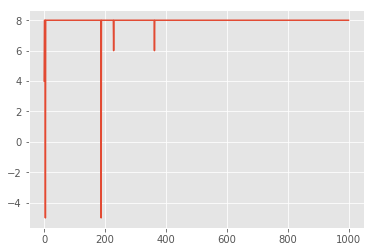

In [31]:
r, q = q_learning(S, A, "入口", "宝", 1000)
plt.plot(range(1000), r)

In [32]:
#Sarsa
def sarsa(S, A, s_0, s_t, n_iter=1000):
    """
    @param S state set
    @param A action set
    @param s_0 initial state
    @param s_t terminal state
    @param n_iter iteration number
    @return reward list of each timestep
    @return q value table
    """
    gamma = 0.9
    #initialize q_table
    q_table = ENV.copy()
    q_table[q_table.notnull()] = 1
    #q_table = pd.DataFrame(np.ones(len(S), len(A)), index=S, columns=A) #optimistic initial value
    #q_table = pd.DataFrame(np.ones(len(S), len(A)) * (-1), index=S, columns=A) #pessimistic initial value
    reward_lst = []
    for k in range(n_iter):
        alpha = 1/(k+1) #0.1
        s = s_0
        a_arg = softmax_boltzman(np.array(q_table.loc[s].copy(), dtype=np.float64), T=1.5)  #change these 2 method
        a = A[a_arg]
        total_r = 0
        while not s == s_t:
            s_next = ENV[a][np.where(S==s)[0][0]]
            r = reward[s_next] - 1
            total_r += r
            a_arg = softmax_boltzman(np.array(q_table.loc[s_next].copy(), dtype=np.float64), T=1.5) #change these 2 method, but s_next
            a_next = A[a_arg]
            q_table[a][s] += alpha * (r + gamma * q_table[a_next][s_next] - q_table[a][s])
            s = s_next
            a = a_next
        reward_lst.append(total_r)
    return reward_lst, q_table

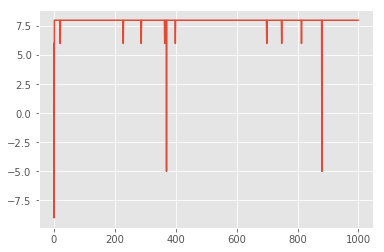

In [36]:
r,q = sarsa(S, A, "入口", "宝", 1000)
plt.plot(range(1000), r)

In [34]:
#バケツリレー・アルゴリズム
def bucket_brigade(S, A, s_0, s_t, c_bid = 0.1 ,n_iter=1000):
    """
    caution:
    ここで扱っているバケツリレーアルゴリズムはp. 47で紹介されたシンプルなものである
    オリジナルのモデルではドントケアなどが組み込まれている ref : p.49
    """
    """
    @param S state set
    @param A action set
    @param s_0 initial state
    @param s_t terminal state
    @param c_bid bid patameter
    @param n_iter iteration number
    @return reward list of each timestep
    @return q value table
    """
    #initialize q_table
    q_table = ENV.copy()
    q_table[q_table.notnull()] = 1
    #q_table = pd.DataFrame(np.ones(len(S), len(A)), index=S, columns=A) #optimistic initial value
    #q_table = pd.DataFrame(np.ones(len(S), len(A)) * (-1), index=S, columns=A) #pessimistic initial value
    reward_lst = []
    for k in range(n_iter):
        s = s_0
        bid_table = c_bid * q_table.copy()
        a_arg = softmax_boltzman(np.array(bid_table.loc[s].copy(), dtype=np.float64), T=1.5)  #change these 2 method
        a = A[a_arg]
        total_r = 0
        while not s == s_t:
            s_next = ENV[a][np.where(S==s)[0][0]]
            r = reward[s_next] - 1
            total_r += r
            bid_table.loc[s_next] =  c_bid * q_table.copy().loc[s_next]
            a_arg = softmax_boltzman(np.array(bid_table.loc[s_next].copy(), dtype=np.float64), T=1.5) #change these 2 method, but s_next
            a_next = A[a_arg]
            q_table[a][s] += (r + bid_table[a_next][s_next] - bid_table[a][s])
            s = s_next
            a = a_next
        reward_lst.append(total_r)
    return reward_lst, q_table

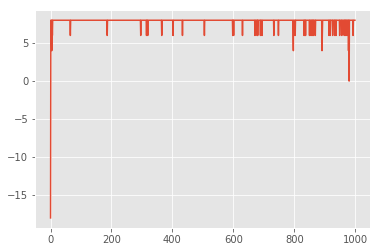

In [35]:
r,q = bucket_brigade(S, A, "入口", "宝", n_iter=1000)
plt.plot(range(1000), r)

In [ ]:
#TD学習
def TD():

### 学習手法(非ブートストラップ型学習)
ref : マルチエージェント学習 p.51 高玉圭樹

In [ ]:
#モンテカルロ法
def MonteCarlo():

In [ ]:
#Profit Sharing
def ProfitSharing():

## マルチエージェント強化学習

### n人繰り返し囚人のジレンマ(n=2)
n人(n>2)に拡張するときの報酬体系は[こちら](https://www.jstage.jst.go.jp/article/sicetr/49/3/49_370/_pdf)を参考に

参考文献
["学習あり繰り返し囚人のジレンマにおける協調行動の発生", JSAI 2014](https://kaigi.org/jsai/webprogram/2014/pdf/699.pdf)

In [124]:
#なんかよくわからんsoftmax
def psuedo_reward(A, act_history, reward_history, alpha, beta=1.0):
    """
    @param A 
    @param act_history  
    @param  reward_history 
    @param alpha 
    @return selected action arg
    """
    def gamma(x, y):
        if x == y:
            return 1
        return 0
    
    K = len(act_history)
    R = np.array([0,0])
    R[0] = np.sum([alpha ** k * gamma("0", act_history[k-1]) * reward_history[k-1] for k in range(1, K+1)])
    R[1] = np.sum([alpha ** k * gamma("1", act_history[k-1]) * reward_history[k-1] for k in range(1, K+1)])
    
    return np.random.choice(["0", "1"], p=(np.exp(R * beta))/np.sum(np.exp(R * beta)))

In [51]:
class Agent:
    def __init__(self, A, agent_id, K):
        self.A = A
        self.agent_id = agent_id
        self.reward = 0
        self.K = K
        self.reward_history = [0] * K
        self.act_history = [""] * K
        
    def reinit(self):
        self.reward = 0
        self.reward_history = [0] * self.K
        self.act_history = [""] * self.K
    
    def random_act(self):
        action = np.random.choice(self.A)
        self.act_history = [action] + self.act_history[:self.K-1]
        return action
    
    def act(self, alpha):
        action = psuedo_reward(self.A, self.act_history, self.reward_history, alpha)
        self.act_history = [action] + self.act_history[:self.K-1]
        return action
        
    def add_reward(self, reward):
        self.reward += reward
        self.reward_history = [reward] + self.reward_history[:self.K-1]

In [48]:
#繰り返し囚人のジレンマゲーム
class IPD:
    def __init__(self, K=10):
        self.K = K
        self.reward_func = {"00":2,"01":0,"10":3,"11":1}
        self.agent0 = Agent(["0", "1"], 0, self.K)
        self.agent1 = Agent(["0", "1"], 1, self.K)
        self.history = []
        
    def run(self, n_iter, alpha=1.0):
        for i in tqdm(range(n_iter)):
            if i < self.K:
                act0 = self.agent0.random_act()
                act1 = self.agent1.random_act()
            else:
                act0 = self.agent0.act(alpha)
                act1 = self.agent1.act(alpha)
                
            reward0 = self.reward_func[act0+act1]
            reward1 = self.reward_func[act1+act0]

            self.agent0.add_reward(reward0)
            self.agent1.add_reward(reward1)
            
            self.history.append(act0+act1)
        
    def reinit(self):
        self.agent0.reinit()
        self.agent1.reinit()
        self.history = []

In [123]:
demo = IPD()
demo.run(50, alpha=1.0)
count_dict = collections.Counter(demo.history)
print(count_dict)

Counter({'11': 37, '01': 8, '00': 3, '10': 2})


In [52]:
#繰り返し行き詰まりゲーム
class IDG:
    def __init__(self, K=10):
        self.K = K
        self.reward_func = {"00":1,"01":0,"10":3,"11":2}
        self.agent0 = Agent(["0", "1"], 0, self.K)
        self.agent1 = Agent(["0", "1"], 1, self.K)
        self.history = []
        
    def run(self, n_iter, alpha=1.0):
        for i in tqdm(range(n_iter)):
            if i < self.K:
                act0 = self.agent0.random_act()
                act1 = self.agent1.random_act()
            else:
                act0 = self.agent0.act(alpha)
                act1 = self.agent1.act(alpha)
                
            reward0 = self.reward_func[act0+act1]
            reward1 = self.reward_func[act1+act0]

            self.agent0.add_reward(reward0)
            self.agent1.add_reward(reward1)
            
            self.history.append(act0+act1)
        
    def reinit(self):
        self.agent0.reinit()
        self.agent1.reinit()
        self.history = []

In [72]:
demo = IPD()
demo.run(50, alpha=0.7)
count_dict = collections.Counter(demo.history)
print(count_dict)

Counter({'00': 44, '11': 3, '01': 2, '10': 1})


### 繰り返し囚人のジレンマ+複雑ネットワーク
参考文献 ["不均質な環境における拡張協調期待戦略の効率と特性", 計算社会科学研究会 Technical Report](http://css-japan.com/wp-content/uploads/2017/02/05.CSSJWS.pdf)

In [ ]:
#繰り返し囚人のジレンマゲーム
class IPD_w_net:
    def __init__(self, K=10):
        self.K = K
        self.reward_func = {"00":3,"01":0,"10":5,"11":1}
        self.agents = self.__create_agents() #ネットワーク上のノードとする
        
        self.history = []
        
    def run(self, n_iter, alpha=1.0):
        for i in tqdm(range(n_iter)):
            if i < self.K:
                act0 = self.agent0.random_act()
                act1 = self.agent1.random_act()
            else:
                act0 = self.agent0.act(alpha)
                act1 = self.agent1.act(alpha)
                
            reward0 = self.reward_func[act0+act1]
            reward1 = self.reward_func[act1+act0]

            self.agent0.add_reward(reward0)
            self.agent1.add_reward(reward1)
            
            self.history.append(act0+act1)
        
    def reinit(self):
        self.agent0.reinit()
        self.agent1.reinit()
        self.history = []